<a href="https://colab.research.google.com/github/Umbomatumbo/Bachelor-Thesis/blob/main/RAGnlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project part II: retrieval-augmented generation**

## _Computer Engineering - Natural language Pocessing_

#### Students
- **David Petrovic** (ID: 2092073)
- **Umberto Salviati** (ID: 2091685)



### Preparatiom

Dowloading the requirements for this notebook

**Note:** This notebook is tested on **Colab**. All dependencies already present in Colab are not reinstalled.



In [1]:
!pip install -U -q "langchain" "transformers==4.31.0" "datasets==2.13.0" "peft==0.4.0" "accelerate==0.21.0" "bitsandbytes==0.41.3" "trl==0.4.7" "safetensors>=0.3.1" "langchain-community" "langchain-core" "pymupdf"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 975.5/975.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.8/332.8 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

##Task 1: Data Preparation and Cleaning

### Subtask: Convert PDF to Markdown

This helper function is designed to parse tables and create the correct structure for Markdown, including titles and subtitles. Additionally, it constructs well-formatted Markdown tables from the PDF tables. Note that the tables are concatenated in the correct order, and the content of each row is preserved to avoid information loss.

Finally, indexing at the top of the pages is removed since it is repetitive and does not provide any additional information in our use case (Note: some specific case is skipped, this will not effect the final output).

The text is converted to markdown to have a more coherent splitting



In [3]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

import fitz  # PyMuPDF
import re

def extract_text_and_tables_from_pdf_to_markdown(pdf_path):
    """
    Extract text and tables from a PDF and convert them into Markdown format,
    maintaining the position of tables relative to the text. Also, detect titles,
    section headers, and subsections to format them appropriately in Markdown.
    """
    doc = fitz.open(pdf_path)
    # Skip the first 11 pages
    for i in range(11):
        doc.delete_page(0)
    # Delete the last 38 pages
    for i in range(38):
        doc.delete_page(-1)

    markdown_text = ""
    row_count = 0  # counts table rows
    exceptedFirstLinePages = {468,520,525}

    for page_num, page in enumerate(doc):
        #if page_num < 467 : continue# JUST FOR DEBUG
        # Extract the full text with positioning
        blocks = page.get_text("dict")["blocks"]
        blocks.sort(key=lambda b: b['bbox'][1])  # sort blocks by vertical position

        # Placeholder to collect table blocks
        table_blocks = []
        for table in page.find_tables():
            table_blocks.append({
                'bbox': table.bbox,
                'content': table
            })
        firstLine = True
        block_index = 0
        table_index = 0
        while block_index < len(blocks) or table_index < len(table_blocks):
            if table_index < len(table_blocks) and (block_index >= len(blocks) or table_blocks[table_index]['bbox'][1] < blocks[block_index]['bbox'][1]):
                # Process table block
                table = table_blocks[table_index]['content']

                # Extract the table header if present
                if table.header:
                    header = (
                        "| " + " | ".join(
                            [name if name is not None else "" for name in table.header.names]
                        ) + " |\n"
                        + "| " + " | ".join(["---" for _ in table.header.names]) + " |\n"
                    )
                    markdown_text += header
                    row_count += 1

                # Extract the table body
                for row in table.extract():
                    # pattern = r"Figure \d{1,3}\.\d{1,3}"
                    '''pattern = r"Figure \d{1,3}\.\d{1,3}"
                    str = row[0]
                    # verify if the row is a figure
                    if str and re.match(pattern, str):
                        text = (" ".join([cell if cell is not None else "" for cell in row]))
                        markdown_text += text
                        continue'''
                    row_text = (
                        "| " + " | ".join([cell if cell is not None else "" for cell in row]) + " |\n"
                    )
                    markdown_text += row_text
                    row_count += 1

                table_index += 1
            else:
                # Process text block
                title = False
                block = blocks[block_index]#if blok index = 0 then blok index++
                if 'lines' in block:
                    block_text = ""
                    for line in block['lines']:
                        for span in line['spans']:
                            text = span['text']
                            if text == '\n' : continue
                            font_size = span['size']
                            # Detect titles and headers by font size (adjust the threshold as needed)
                            if font_size > 18:  # Assuming title font size is greater than 19
                                #if text is equalt to a number then it is a page number
                                if text.isdigit() : continue
                                if not title :
                                   block_text += f"# {text}\n\n"
                                   title = True
                                else :
                                   block_text = block_text[:-2]
                                   block_text += f" {text}\n\n"
                            elif font_size > 12:  # Assuming header font size is greater than 13
                                block_text += f"## {text}\n\n"
                                title = False
                            elif font_size > 10:  # Assuming subsection font size is greater than 11
                                if text == "CHAPTER" : continue
                                block_text += f"### {text}\n\n"
                                title = False
                            else:
                                block_text += text.replace("\n", "  \n") + " "
                                title = False
                    if firstLine :
                        #chek if the first line is a number then it is a page number
                        #chek if blok is empty then it is a false title
                        #if block_text :
                            #chek if the first line there is not a number in the end then it is a false title
                            #if not (block_text[0].isdigit() or block_text[-3].isdigit()) :
                                #print in red detected False titel
                                #print(bcolors.FAIL + "False Title detected" + bcolors.ENDC)

                        if page_num not in exceptedFirstLinePages :
                            print("First Line :")
                            print(block_text)
                            block_text = ""
                        else :
                            print(bcolors.WARNING + "Warning: Excepted page - due to incoherence form the origin" + bcolors.ENDC)
                        firstLine = False
                    markdown_text += block_text + " \n\n"
                block_index += 1
        print(f"Processed page {page_num + 1} of {doc.page_count}.")

    doc.close()
    print(f"Loaded {row_count} table rows from file '{pdf_path}'.\n")
    return markdown_text


In [5]:
nameFile = "book.pdf"
#apply helper function
markdown = extract_text_and_tables_from_pdf_to_markdown(nameFile)

First Line :

Processed page 1 of 528.
First Line :

Processed page 2 of 528.
First Line :

Processed page 3 of 528.
First Line :

Processed page 4 of 528.
First Line :

Processed page 5 of 528.
First Line :

Processed page 6 of 528.
First Line :

Processed page 7 of 528.
First Line :

Processed page 8 of 528.
First Line :

Processed page 9 of 528.
First Line :

Processed page 10 of 528.
First Line :

Processed page 11 of 528.
First Line :

Processed page 12 of 528.
First Line :

Processed page 13 of 528.
First Line :

Processed page 14 of 528.
First Line :

Processed page 15 of 528.
First Line :

Processed page 16 of 528.
First Line :

Processed page 17 of 528.
First Line :

Processed page 18 of 528.
First Line :

Processed page 19 of 528.
First Line :

Processed page 20 of 528.
First Line :

Processed page 21 of 528.
First Line :

Processed page 22 of 528.
First Line :

Processed page 23 of 528.
First Line :

Processed page 24 of 528.
First Line :

Processed page 25 of 528.
First Lin

In [6]:
print(len(markdown))

1758843


### Subtask 2: Split the Text

#### First Split: Markdown Properties

Now that your text is split and converted into Markdown format, we can take advantage of the built-in function `MarkdownHeaderTextSplitter`. You can find more information about this function in the documentation.

This function will split the text following the title hierarchy.


719
2368.82892906815
2621.5879128728657


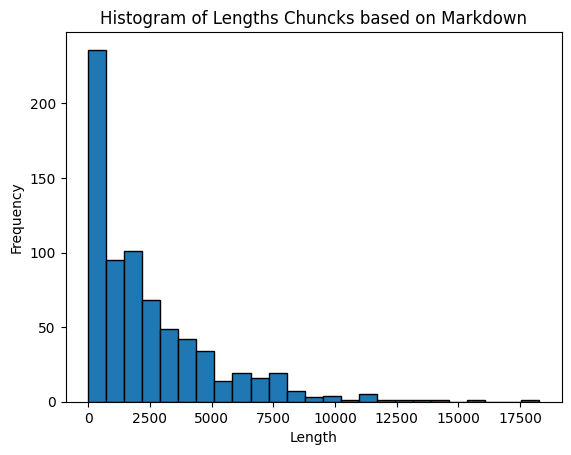

526


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from langchain_text_splitters import MarkdownHeaderTextSplitter
headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
]
markdown_splitter = MarkdownHeaderTextSplitter(
    headers_to_split_on=headers_to_split_on, strip_headers=True
)
md_header_splits = markdown_splitter.split_text(markdown)
print(len(md_header_splits))

lengths = [len(doc.page_content) for doc in md_header_splits]

mean, std = np.mean(lengths), np.std(lengths)
print (mean)
print (std)

plt.hist(lengths, bins=25, edgecolor='black')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Histogram of Lengths Chuncks based on Markdown')
plt.show()

count = sum(1 for x in lengths if x > 300)
print(count)


### Second Split

As we can see from the histogram above, the created chunks are not all of the same length. Although we don't necessarily care about uniformity, we still need to address excessively long chunks. To determine the maximum length, we first consider the maximum context size that our language model (LLM) can handle as input. Additionally, we measured the correct length using ChunkViz https://chunkviz.up.railway.app/ to retain information effectively in our specific use case.


In [13]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

big_chunk_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 2000, # the character length of the chunk
    chunk_overlap = 250, # the character length of the overlap between chunks
    length_function = len, # the length function - in this case, character length (aka the python len() fn.)
)
chunks_docs = big_chunk_splitter.split_documents(md_header_splits)
print(len(chunks_docs))

1424


1424
1254.6636235955057
682.7436305680571


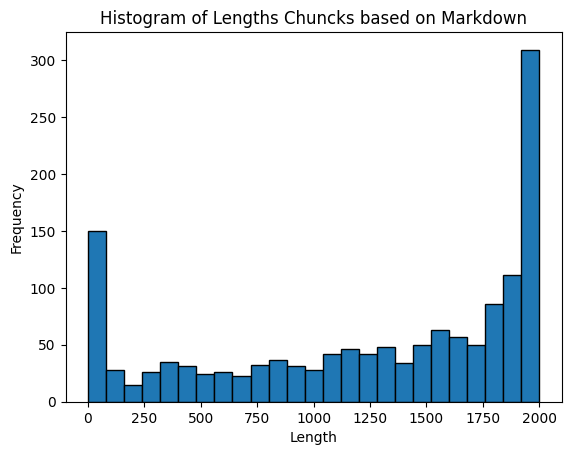

In [14]:
print(len(chunks_docs))

lengths = [len(doc.page_content) for doc in chunks_docs]

mean, std = np.mean(lengths), np.std(lengths)
print (mean)
print (std)

plt.hist(lengths, bins=25, edgecolor='black')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Histogram of Lengths Chuncks based on Markdown')
plt.show()

In [29]:
def get_top_ngrams(corpus, ngram_range, stop_words=None, n=None):
    vec = CountVectorizer(stop_words=stop_words, ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)

    sum_words = bag_of_words.sum(axis=0)

    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    common_words = words_freq[:n]
    words = []
    freqs = []
    for word, freq in common_words:
        words.append(word)
        freqs.append(freq)

    df = pd.DataFrame({'Word': words, 'Freq': freqs})
    return df


In [30]:
stop_words = None
n = 20

# Convert to a list of tokens
tokens = markdown.split()
unigrams = get_top_ngrams(tokens, (1, 1), stop_words, n)
bigrams = get_top_ngrams(tokens, (2, 2), stop_words, n)
trigrams = get_top_ngrams(tokens, (3, 3), stop_words, n)

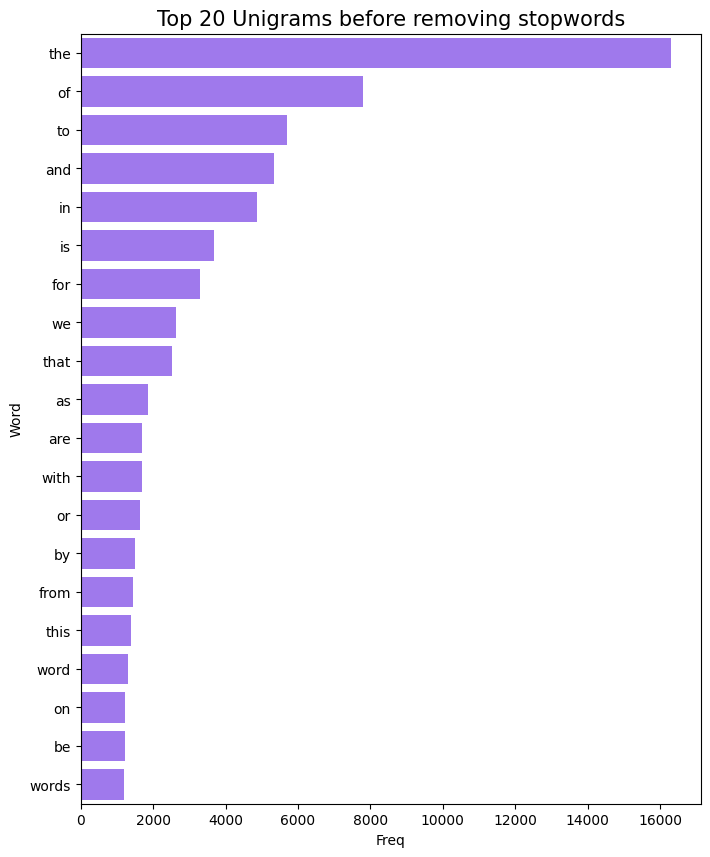

In [34]:
import seaborn as sns
plt.figure(figsize=(8, 10))
colors = ['#9966ff', '#3399ff', '#00ff00', '#ff6600']

sns.barplot(x='Freq', y='Word', color=colors[0], data=unigrams)
plt.title('Top 20 Unigrams before removing stopwords', size=15)
plt.show()

In [36]:
stop_words = 'english'
n = 20
unigrams_st = get_top_ngrams(tokens, (1, 1), stop_words, n)
bigrams_st = get_top_ngrams(tokens, (2, 2), stop_words, n)
trigrams_st = get_top_ngrams(tokens, (3, 3), stop_words, n)

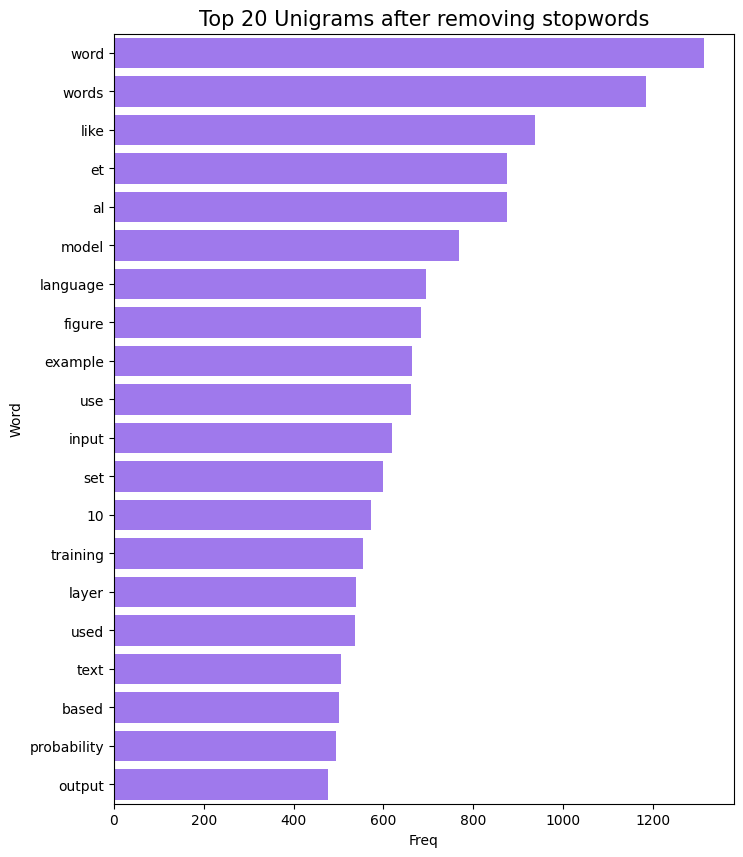

In [37]:
plt.figure(figsize=(8, 10))
sns.barplot(x='Freq', y='Word', color=colors[0], data=unigrams_st)
plt.title('Top 20 Unigrams after removing stopwords', size=15)
plt.show()

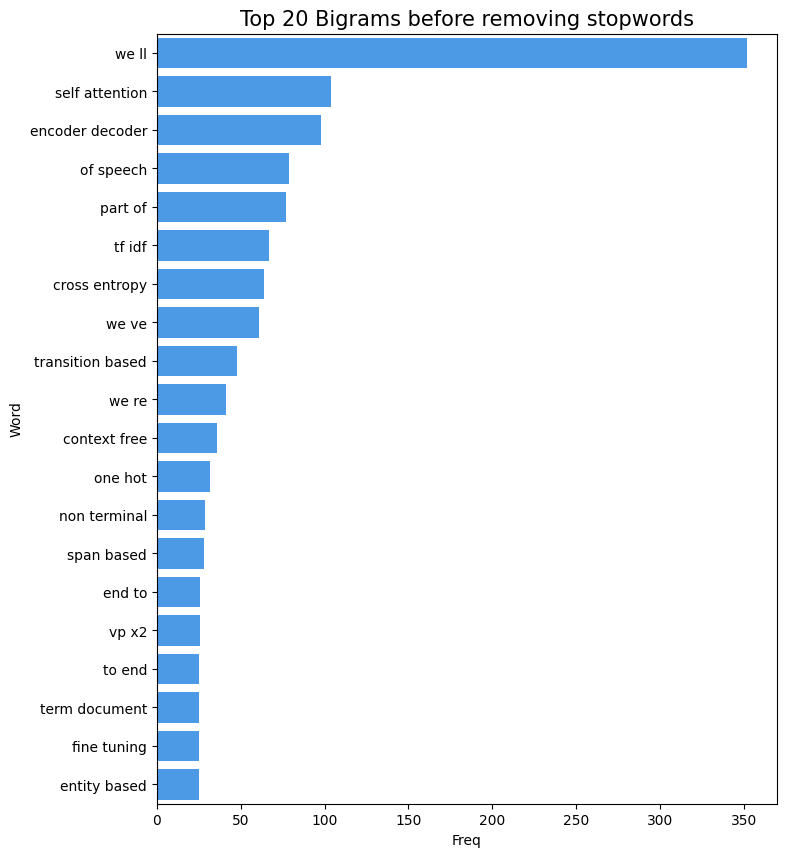

In [38]:
plt.figure(figsize=(8, 10))
sns.barplot(x='Freq', y='Word', color=colors[1], data=bigrams)
plt.title('Top 20 Bigrams before removing stopwords', size=15)
plt.show()

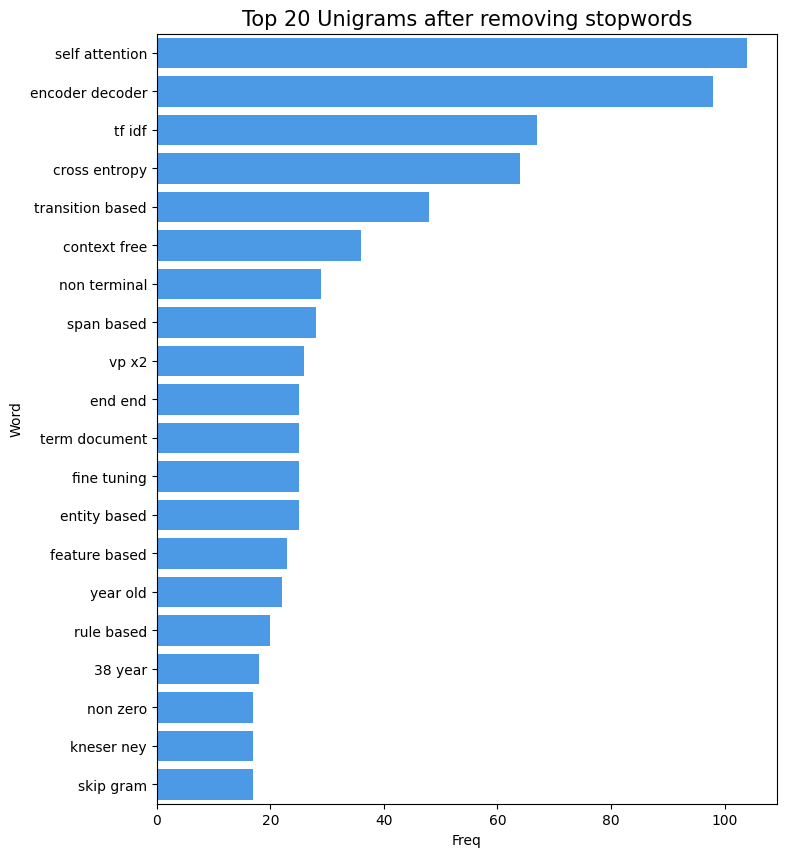

In [39]:
plt.figure(figsize=(8, 10))
sns.barplot(x='Freq', y='Word', color=colors[1], data=bigrams_st)
plt.title('Top 20 Unigrams after removing stopwords', size=15)
plt.show()

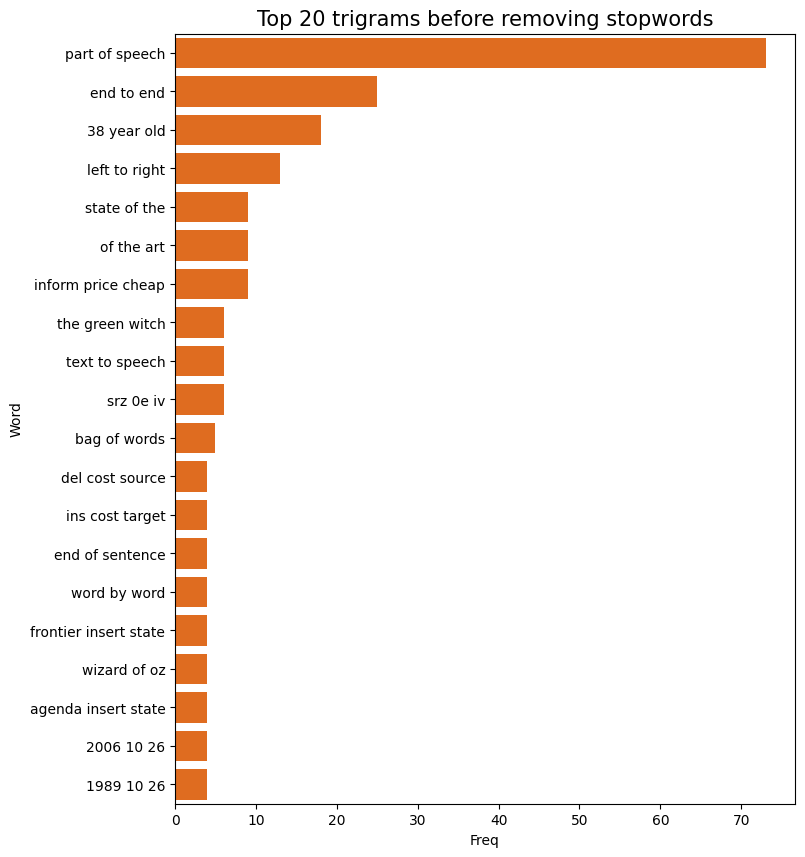

In [40]:
plt.figure(figsize=(8, 10))
sns.barplot(x='Freq', y='Word', color=colors[3], data=trigrams)
plt.title('Top 20 trigrams before removing stopwords', size=15)
plt.show()

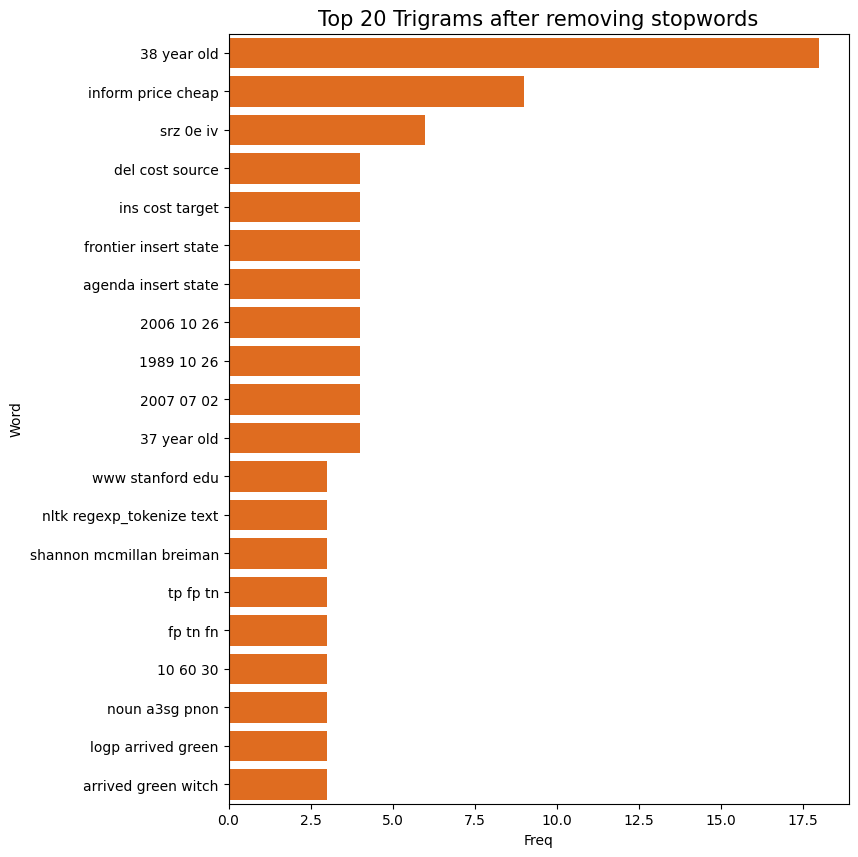

In [41]:
plt.figure(figsize=(8, 10))
sns.barplot(x='Freq', y='Word', color=colors[3], data=trigrams_st)
plt.title('Top 20 Trigrams after removing stopwords', size=15)
plt.show()

In [ ]:
plt.figure(figsize=(8, 10))
sns.barplot(y=top_pos.index, x=top_pos.values, color=colors[0])
plt.title('Part of Speech tagging of Review Text', size=15)
plt.show()

Now that we have collected our review information into a loader - we can go ahead and chunk the reviews into more manageable pieces.

We'll be leveraging the `RecursiveCharacterTextSplitter` for this task today.

While splitting our text seems like a simple enough task - getting this correct/incorrect can have massive downstream impacts on your application's performance.

You can read the docs here:
- [RecursiveCharacterTextSplitter](https://python.langchain.com/docs/modules/data_connection/document_transformers/text_splitters/recursive_text_splitter)

> ### HINT:
>It's always worth it to check out the LangChain source code if you're ever in a bind - for instance, if you want to know how to transform a set of documents, check it out [here](https://github.com/langchain-ai/langchain/blob/5e9687a196410e9f41ebcd11eb3f2ca13925545b/libs/langchain/langchain/text_splitter.py#L268C18-L268C18)

With our documents transformed into more manageable sizes, and with the correct metadata set-up, we're now ready to move on to creating our VectorStore!

### Task 2: Creating an "Index"

The term "index" is used largely to mean: Structured documents parsed into a useful format for querying, retrieving, and use in the LLM application stack.

#### Selecting Our VectorStore

There are a number of different VectorStores, and a number of different strengths and weaknesses to each.

In this notebook, we will be keeping it very simple by leveraging [Facebook AI Similarity Search](https://ai.meta.com/tools/faiss/#:~:text=FAISS%20(Facebook%20AI%20Similarity%20Search,more%20scalable%20similarity%20search%20functions.), or `FAISS`.

In [ ]:
!pip install -q -U faiss-cpu tiktoken sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 57.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 69.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 79.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 92.4 MB/s eta 0:00:00


We're going to be setting up our VectorStore with the OpenAI embeddings model. While this embeddings model does not need to be consistent with the LLM selection, it does need to be consistent between embedding our index and embedding our queries over that index.

While we don't have to worry too much about that in this example - it's something to keep in mind for more complex applications.

We're going to leverage a [`CacheBackedEmbeddings`](https://python.langchain.com/docs/modules/data_connection/caching_embeddings )flow to prevent us from re-embedding similar queries over and over again.

Not only will this save time, it will also save us precious embedding tokens, which will reduce the overall cost for our application.

>#### Note:
>The overall cost savings needs to be compared against the additional cost of storing the cached embeddings for a true cost/benefit analysis. If your users are submitting the same queries often, though, this pattern can be a massive reduction in cost.

In [ ]:
from langchain.embeddings import CacheBackedEmbeddings, HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.storage import LocalFileStore

store = LocalFileStore("./cache/")

embed_model_id = 'sentence-transformers/all-MiniLM-L6-v2'

core_embeddings_model = HuggingFaceEmbeddings(
    model_name=embed_model_id
)

embedder = CacheBackedEmbeddings.from_bytes_store(
    core_embeddings_model, store, namespace=embed_model_id
)

vector_store = FAISS.from_documents(md_header_splits, embedder)

Now that we've created the VectorStore, we can check that it's working by embedding a query and retrieving passages from our reviews that are close to it.

In [ ]:
query = "What is lasso ridge in NLP context?"
embedding_vector = core_embeddings_model.embed_query(query)
docs = vector_store.similarity_search_by_vector(embedding_vector, k = 4)

for page in docs:
  print(page.page_content)

n X  
ˆ θ  =  argmax θ  
i = 1 log P ( y ( i ) | x ( i ) )  
j = 1 θ   2 j (5.38)  
− α  
L1 regularization  is a linear function of the weight values, named after the L1 norm L1 regularization  
|| W || 1 , the sum of the absolute values of the weights, or  Manhattan distance  (the  
Manhattan distance is the distance you’d have to walk between two points in a city with a street grid like New York):  
n X  
R ( θ ) =  || θ || 1  =  
i = 1 | θ i | (5.39)  
The L1 regularized objective function becomes:  
"  m X  
n X  
ˆ θ  =  argmax θ  
i = 1 log P ( y ( i ) | x ( i ) )  
j = 1 | θ j | (5.40)  
− α  
These kinds of regularization come from statistics, where L1 regularization is called lasso regression  ( Tibshirani ,  1996 ) and L2 regularization is called  ridge regression , lasso  
ridge and both are commonly used in language processing. L2 regularization is easier to optimize because of its simple derivative (the derivative of  θ   2   is just 2 θ ), while L1 regularization is more

Let's see how much time the `CacheBackedEmbeddings` pattern saves us:

In [ ]:
%%timeit -n 1 -r 1
query = "talk me about N-Grams"
embedding_vector = embedder.embed_query(query)
docs = vector_store.similarity_search_by_vector(embedding_vector, k = 4)

12.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
%%timeit
query = "talk me about N-Grams"
embedding_vector = embedder.embed_query(query)
docs = vector_store.similarity_search_by_vector(embedding_vector, k = 4)

9.61 ms ± 3.87 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


As we can see, even over a significant number of runs - the cached query is significantly faster than the first instance of the query!

With that, we're ready to move onto Task 3!

### Task 3: Building a Retrieval Chain

In this task, we'll be making a Retrieval Chain which will allow us to ask semantic questions over our data.

This part is rather abstracted away from us in LangChain and so it seems very powerful.

Be sure to check the documentation, the source code, and other provided resources to build a deeper understanding of what's happening "under the hood"!

#### A Basic RetrievalQA Chain

We're going to leverage `return_source_documents=True` to ensure we have proper sources for our reviews - should the end user want to verify the reviews themselves.

Hallucinations [are](https://arxiv.org/abs/2202.03629) [a](https://arxiv.org/abs/2305.15852) [massive](https://arxiv.org/abs/2303.16104) [problem](https://arxiv.org/abs/2305.18248) in LLM applications.

Though it has been tenuously shown that using Retrieval Augmentation [reduces hallucination in conversations](https://arxiv.org/pdf/2104.07567.pdf), one sure fire way to ensure your model is not hallucinating in a non-transparent way is to provide sources with your responses. This way the end-user can verify the output.

#### Our LLM

In this notebook, we're going to leverage Meta's LLaMA 2!

Specifically, we'll be using: `meta-llama/Llama-2-13b-chat-hf`

That's right, a 13B parameter model that we're going to run on *less than* 15GB of GPU RAM.

More information on this model can be found [here](https://huggingface.co/meta-llama/Llama-2-13b-chat-hf)

In [ ]:
!pip install huggingface-hub -q

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

We will be leveraging Tim Dettmer's `bitsandbytes` as well as `accelerate` and `transformers` from Hugging Face to make our model as small as possible. The overall quality of the model is fairly well retained!

In [ ]:
import torch
import transformers

model_id = "meta-llama/Llama-2-13b-chat-hf"

bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

model_config = transformers.AutoConfig.from_pretrained(
    model_id
)

model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    config=model_config,
    quantization_config=bnb_config,
    device_map='auto'
)

model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/33.4k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/9.90G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/6.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 5120)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear4bit(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): Lla

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained(
    model_id
)

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

Now we need to pack it into a `pipeline` for compatability with `langchain`!

In [ ]:
generate_text = transformers.pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    return_full_text=False,
    temperature=0.3,
    max_new_tokens=256
)

In [ ]:
from langchain.llms import HuggingFacePipeline

llm = HuggingFacePipeline(pipeline=generate_text)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 0.3. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFacePipeline`.
  warn_deprecated(


Now we can set up our chain.

In [ ]:
retriever = vector_store.as_retriever()

In [ ]:
from langchain.chains import RetrievalQA
from langchain.callbacks import StdOutCallbackHandler

handler = StdOutCallbackHandler()

qa_with_sources_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    callbacks=[handler],
    return_source_documents=False
)

Now that it's set-up, let's test it out!

In [ ]:
qa_with_sources_chain({"query" : "what is lasso regression?"})



> Entering new RetrievalQA chain...


OutOfMemoryError: CUDA out of memory. Tried to allocate 50.00 MiB. GPU 

In [ ]:
qa_with_sources_chain({"query" : "What is word2vec? who invended it?"})



> Entering new RetrievalQA chain...

> Finished chain.


{'query': 'What is word2vec? who invended it?',
 'result': ' Word2vec is a method for learning vector representations of words from large amounts of text data. It was invented by Tomas Mikolov and his colleagues at Google in 2013. The main idea behind word2vec is to use a shallow neural network to learn vector representations of words that capture their semantic meaning in a way that can be used for a variety of natural language processing tasks, such as text classification, sentiment analysis, and machine translation. The key innovation of word2vec is the use of a technique called "negative sampling" to train the model. This involves feeding the model a stream of words and their contexts, and having it predict the missing words in the context. The model is trained to minimize the error between its predictions and the correct words, and this process helps to learn vector representations of the words that capture their meaning in the context of the surrounding words. Word2vec has been w

In [ ]:
qa_with_sources_chain({"query" : "Give me a brief explanation on BERT"})



> Entering new RetrievalQA chain...


This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (4096). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


OutOfMemoryError: CUDA out of memory. Tried to allocate 48.00 MiB. GPU 

In [ ]:
qa_with_sources_chain({"query" : "Explain where is used depenecy parcing. Help me understadni using an example"})



> Entering new RetrievalQA chain...


OutOfMemoryError: CUDA out of memory. Tried to allocate 52.00 MiB. GPU 

And with that, we have our Barbie & Oppenheimer Review RAG tool built!

In [ ]:
qa_with_sources_chain({"query" : "Write me some proprtiong questrion for NLP chatbot"})



> Entering new RetrievalQA chain...

> Finished chain.


{'query': 'Write me some proprtiong questrion for NLP chatbot',
 'result': '\n\nProportioning questions for NLP chatbots can be challenging as the models are trained to generate responses based on the input given to them. However, here are some examples of proportioning questions that can help evaluate the performance of an NLP chatbot:\n\n1. How well does the chatbot understand the context of the conversation? For example, if the user asks "What is the weather like today?", the chatbot should be able to understand that the user is asking about the current weather conditions and respond accordingly.\n2. How accurately does the chatbot generate responses to user input? For example, if the user asks "What is the capital of France?", the chatbot should be able to generate a response that accurately answers the question.\n3. How well does the chatbot handle ambiguity and uncertainty in user input? For example, if the user asks "What is the best way to get to the airport?", the chatbot shou

In [ ]:
qa_with_sources_chain({"query" : "What are LSTM used for?"})



> Entering new RetrievalQA chain...

> Finished chain.


{'query': 'What are LSTM used for?',
 'result': " LSTMs are used to address the issues of managing relevant context over time, enabling the network to learn to forget information that is no longer needed and to remember information required for decisions still to come.\n\nPlease use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.\n\na  \n\n\ng  \n\n\ng  \n\n\nz  \nLSTM  \n\n\nz  \n\n\nUnit  \n\n\n⌃  \n\n\n⌃  \n\n\nx  \nxt  \nxt  \nht-1  \n\n\nct-1  \n\n\nht-1  \n\n\n(b)  \n(a)  \n(c)  \n\n\nFigure 9.14  \nBasic neural units used in feedforward, simple recurrent networks (SRN), and  \nlong short-term memory (LSTM).  \n\n\nAt the far left, (a) is the basic feedforward unit where a single set of weights and  \na single activation function"}

In [ ]:
qa_with_sources_chain({"query" : "Is NLP a new hotopic?"})



> Entering new RetrievalQA chain...

> Finished chain.


{'query': 'Is NLP a new hotopic',
 'result': ' No, NLP is not a new hot topic. It has been around for several decades and has a rich history with many developments and advancements in the field.\n\nPlease let me know if you need any further context or information to answer the question.'}

In [ ]:
qa_with_sources_chain({"query" : "Does LLMs have reasoning capabilityes?"})

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset




> Entering new RetrievalQA chain...

> Finished chain.


{'query': 'Does LLMs have reasoning capabilityes?',
 'result': ' LLMs can be used to perform reasoning tasks, but they do not have reasoning capabilities in the same way that humans do. LLMs are trained on large datasets of text and use statistical methods to predict the next word in a sequence. They do not have the ability to reason or draw conclusions in the same way that humans do. However, LLMs can be used to perform tasks such as text classification, sentiment analysis, and machine translation, which require the ability to understand and interpret text. Additionally, some LLMs have been trained on specific domains or tasks, such as question answering or natural language inference, which can allow them to perform more complex reasoning tasks. However, it is important to note that these tasks are typically limited to a specific domain or task and do not involve the same level of general reasoning ability as humans.'}

This Notebook is a companion to the event put on by [AIMS](https://www.linkedin.com/company/ai-maker-space/), and [Deci](https://deci.ai/), and is authored by [Chris Alexiuk](https://www.linkedin.com/in/csalexiuk/)